# Text Parsing 101

## Import necessary libs

In [1]:
from collections import defaultdict, Counter
import re

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from typing import Dict, List, Tuple, Union

from langdetect import detect
import pdfplumber
import docx2txt

from tqdm.notebook import tqdm
from nltk import word_tokenize
import networkx as nx
sns.set()
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')
# define constants for tagsets
TAGSETS_EN = dict(CC='conjunction', CD='numeral', 
               DT='determiner', EX='existential', 
               IN='preposition', JJ='adjective',
               MD='modal', NN='noun',
               RB='adverb', RP='particle',
               VB='verb')
TAGSETS_RU = dict(CONJ='conjunction', NUM='numeral', 
               PR='preposition', A='adjective', S='noun',
               ADV='adverb', PART='particle',
               V='verb')
STOPWORDS_UK = ['а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї', 'абичиїй', 'абичиїм', 'абичиїми', 'абичиїх', 'абичого', 'абичому', 'абищо', 'абияка', 'абияке', 'абиякий', 'абияким', 'абиякими', 'абияких', 'абиякого', 'абиякому', 'абиякою', 'абиякої', 'абияку', 'абиякі', 'абиякій', 'абиякім', 'або', 'абощо', 'авжеж', 'авось', 'ага', 'ад', 'адже', 'аж', 'ажень', 'аз', 'ай', 'але', 'ало', 'амінь', 'ант', 'ану', 'ані', 'аніде', 'аніж', 'анізащо', 'аніким', 'анікого', 'анікогісінько', 'аніколи', 'анікому', 'аніскільки', 'аніхто', 'анічим', 'анічого', 'анічогісінько', 'анічому', 'аніщо', 'аніяка', 'аніяке', 'аніякий', 'аніяким', 'аніякими', 'аніяких', 'аніякого', 'аніякому', 'аніякою', 'аніякої', 'аніяку', 'аніякі', 'аніякій', 'аніякім', 'аніякісенька', 'аніякісеньке', 'аніякісенький', 'аніякісеньким', 'аніякісенькими', 'аніякісеньких', 'аніякісенького', 'аніякісенькому', 'аніякісенькою', 'аніякісенької', 'аніякісеньку', 'аніякісенькі', 'аніякісенькій', 'аніякісенькім', 'аніякісінька', 'аніякісіньке', 'аніякісінький', 'аніякісіньким', 'аніякісінькими', 'аніякісіньких', 'аніякісінького', 'аніякісінькому', 'аніякісінькою', 'аніякісінької', 'аніякісіньку', 'аніякісінькі', 'аніякісінькій', 'аніякісінькім', 'ат', 'ато', 'атож', 'ау', 'ах', 'ач', 'ачей', 'аякже', 'б', 'ба', 'багато', 'багатьма', 'багатьом', 'багатьох', 'баз', 'бай', 'бат', 'бах', 'бац', 'баш', 'бе', 'беж', 'без', 'безперервно', 'бел', 'бер', 'би', 'бир', 'бич', 'близько', 'близько від', 'бо', 'бов', 'бод', 'бодай', 'боз', 'бош', 'був', 'буває', 'буде', 'будем', 'будемо', 'будете', 'будеш', 'буду', 'будуть', 'будь', 'будь ласка', 'будьмо', 'будьте', 'була', 'були', 'було', 'бути', 'бух', 'буц', 'буцім', 'буцімто', 'бі', 'біб', 'більш', 'більше', 'біля', 'в', 'в бік', 'в залежності від', 'в міру', 'в напрямі до', 'в порівнянні з', 'в процесі', 'в результаті', 'в ролі', 'в силу', 'в сторону', 'в супроводі', 'в ході', "в ім'я", 'в інтересах', 'вад', 'важлива', 'важливе', 'важливий', 'важливі', 'вак', 'вам', 'вами', 'ван', 'вас', 'ват', 'ваш', 'ваша', 'ваше', 'вашим', 'вашими', 'ваших', 'вашого', 'вашому', 'вашою', 'вашої', 'вашу', 'ваші', 'вашій', 'вашім', 'ввесь', 'вві', 'вгору', 'вдалині', 'вед', 'верх', 'весь', 'вех', 'вже', 'вздовж', 'ви', 'виз', 'вис', 'височині', 'вище ', 'вйо', 'власне', 'властиво', 'вміти', 'внаслідок', 'вниз', 'внизу', 'во', 'вон', 'вона', 'вони', 'воно', 'восьмий', 'вперед', 'вподовж', 'впоперек', 'впритиск', 'впритул', 'впродовж', 'впрост', 'все', 'всередині', 'всею', 'вслід', 'всупереч', 'всього', 'всьому', 'всю', 'всюди', 'вся', 'всяк', 'всяка', 'всяке', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякому', 'всякою', 'всякої', 'всяку', 'всякі', 'всякій', 'всякім', 'всі', 'всій', 'всіляка', 'всіляке', 'всілякий', 'всіляким', 'всілякими', 'всіляких', 'всілякого', 'всілякому', 'всілякою', 'всілякої', 'всіляку', 'всілякі', 'всілякій', 'всілякім', 'всім', 'всіма', 'всіх', 'всією', 'всієї', 'втім', 'ві', 'віг', 'від', 'від імені', 'віддалік від', 'відколи', 'відносно', 'відповідно', 'відповідно до', 'відсотків', 'відтепер', 'відтоді', 'він', 'вісім', 'вісімнадцятий', 'вісімнадцять', 'віт', 'віф', 'віх', 'віц', 'віщо', 'віщось', 'г', 'га', 'гав', 'гаразд', 'ге', 'гез', 'гем', 'геп', 'гет', 'геть', 'гех', 'ги', 'гик', 'гир', 'гич', 'гм', 'го', 'говорив', 'гог', 'гоп', 'гоц', 'гу', 'гуп', 'д', 'да', 'давай', 'давати', 'давно', 'далеко', 'далеко від', 'далі', 'даром', 'два', 'двадцятий', 'двадцять', 'дванадцятий', 'дванадцять', 'двох', 'дві', 'де', "дев'ятий", "дев'ятнадцятий", "дев'ятнадцять", "дев'ять", 'дедалі', 'деким', 'декого', 'деколи', 'декому', 'декотра', 'декотре', 'декотрий', 'декотрим', 'декотрими', 'декотрих', 'декотрого', 'декотрому', 'декотрою', 'декотрої', 'декотру', 'декотрі', 'декотрій', 'декотрім', 'декілька', 'декільком', 'декількома', 'декількох', 'декім', 'десь', 'десятий', 'десять', 'дехто', 'дечий', 'дечийого', 'дечийому', 'дечим', 'дечию', 'дечия', 'дечиє', 'дечиєму', 'дечиєю', 'дечиєї', 'дечиї', 'дечиїй', 'дечиїм', 'дечиїми', 'дечиїх', 'дечого', 'дечому', 'дечім', 'дещо', 'деяка', 'деяке', 'деякий', 'деяким', 'деякими', 'деяких', 'деякого', 'деякому', 'деякою', 'деякої', 'деяку', 'деякі', 'деякій', 'деякім', 'деінде', 'для', 'до', 'добре', 'довго', 'довкола', 'довкіл', 'дог', 'доки', 'допоки', 'допіру', 'досить', 'досі', 'дотепер', 'доти', 'другий', 'друго', 'дуже', 'дякую', 'дійсно', 'діл', 'е', 'еге', 'еж', 'ей', 'ерг', 'ест', 'ет', 'ех', 'еч', 'ж', 'же', 'жоден', 'жодна', 'жодне', 'жодний', 'жодним', 'жодними', 'жодних', 'жодного', 'жодному', 'жодною', 'жодної', 'жодну', 'жодні', 'жодній', 'жоднім', 'жоднісінька', 'жоднісіньке', 'жоднісінький', 'жоднісіньким', 'жоднісінькими', 'жоднісіньких', 'жоднісінького', 'жоднісінькому', 'жоднісінькою', 'жоднісінької', 'жоднісіньку', 'жоднісінькі', 'жоднісінькій', 'жоднісінькім', 'жуз', 'з', 'з метою', 'з нагоди', 'з приводу', 'з розрахунку на', 'з-за', 'з-над', 'з-перед', 'з-поза', 'з-поміж', 'з-понад', 'з-поперед', 'з-посеред', 'з-проміж', 'з-під', 'з-серед', 'за', 'за винятком', 'за допомогою', 'за посередництвом', 'за рахунок', 'завгодно', 'завдяки', 'завжди', 'завше', 'задля', 'зазвичай', 'зайнята', 'зайнятий', 'зайнято', 'зайняті', 'залежно', 'залежно від', 'замість', 'занадто', 'заради', 'зараз', 'зас', 'зате', 'збоку', 'збоку від', 'зважаючи на', 'зверх ', 'зверху', 'звичайно', 'звиш', 'звідки', 'звідкилясь', 'звідкись', 'звідкіль', 'звідкіля', 'звідкілясь', 'звідси', 'звідсіль', 'звідсіля', 'звідти', 'звідтіль', 'звідтіля', 'звідусюди', 'звідусіль', 'звідціля', 'згідно з', 'здається', 'здовж', 'зем', 'зет', 'ззаду', 'зиз', 'зик', 'значить', 'знову', 'зо', 'зовсім', 'зсередини', 'зух', 'зі', 'зіс', 'и', 'ич', 'й', 'ймовірно', 'йно', 'йо', 'його', 'йой', 'йол', 'йому', 'йор', 'йот', 'йох', 'к', 'каже', 'каз', 'кар', 'каф', 'ках', 'ке', 'кед', 'кет', 'кеш', 'кив', 'кий', 'кил', 'ким', 'кимось', 'кимсь', 'ких', 'киш', 'коб', 'коби', 'кого', 'когось', 'кожен', 'кожна', 'кожне', 'кожний', 'кожним', 'кожними', 'кожних', 'кожного', 'кожному', 'кожною', 'кожної', 'кожну', 'кожні', 'кожній', 'кожнім', 'кожнісінька', 'кожнісіньке', 'кожнісінький', 'кожнісіньким', 'кожнісінькими', 'кожнісіньких', 'кожнісінького', 'кожнісінькому', 'кожнісінькою', 'кожнісінької', 'кожнісіньку', 'кожнісінькі', 'кожнісінькій', 'кожнісінькім', 'коли', 'колись', 'коло', 'кому', 'комусь', 'котра', 'котрась', 'котре', 'котресь', 'котрий', 'котрийсь', 'котрим', 'котрими', 'котримись', 'котримось', 'котримсь', 'котрих', 'котрихось', 'котрихсь', 'котрого', 'котрогось', 'котрому', 'котромусь', 'котрою', 'котроюсь', 'котрої', 'котроїсь', 'котру', 'котрусь', 'котрі', 'котрій', 'котрійсь', 'котрім', 'котрімсь', 'котрісь', 'коц', 'коч', 'коштом', 'край', 'краще', 'кру', 'круг', 'кругом', 'крю', 'кря', 'крізь', 'крім', 'куди', 'кудись', 'кудою', 'кілька', 'кільком', 'кількома', 'кількох', 'кім', 'кімось', 'кімсь', 'кінець', 'л', 'лаж', 'лап', 'лас', 'лат', 'ле', 'ледве', 'ледь', 'лет', 'лиш', 'лише', 'лишень', 'лум', 'луп', 'лут', 'льє', 'люди', 'людина', 'ля', 'лі', 'ліворуч від', 'лік', 'лім', 'м', 'мабуть', 'майже', 'мало', 'мати', 'мац', 'ме', 'меж', 'мене', 'менше', 'мені', 'мерсі', 'мет', 'мжа', 'ми', 'мимо ', 'миру', 'мит', 'мною', 'мо', 'мов', 'мовби', 'мовбито', 'могла', 'могли', 'могло', 'мого', 'могти', 'мож', 'може', 'можем', 'можемо', 'можете', 'можеш', 'можна', 'можу', 'можуть', 'можіть', 'мой', 'мол', 'мою', 'моя', 'моє', 'моєму', 'моєю', 'моєї', 'мої', 'моїй', 'моїм', 'моїми', 'моїх', 'му', 'мі', 'міг', 'між', 'мій', 'мільйонів', 'н', 'на', 'на адресу', 'на базі', 'на благо', 'на випадок', 'на відміну від', 'на засадах', 'на знак', 'на зразок', 'на користь', 'на кшталт', 'на межі', 'на основі', 'на противагу', 'на підставі', 'на честь', 'на чолі', 'на ґрунті', 'навколо', 'навкруг', 'навкруги ', 'навкіл', 'навпаки', 'навперейми', 'навпроти', 'навіть', 'навіщо', 'навіщось', 'нагорі', 'над', 'надо', 'надовкола', 'надокола', 'наді', 'назавжди', 'назад', 'назустріч', 'най', 'найбільш', 'нам', 'нами', 'наоколо ', 'наокруг ', 'наокруги ', 'наокіл', 'наперед', 'напередодні', 'напереді', 'наперекір', 'напереріз', 'наприкінці', 'напроти', 'нарешті', 'нарівні з', 'нас', 'насеред', 'насподі', 'наспід', 'настрічу', 'насупроти', 'насупротив ', 'нате', 'наче', 'начеб', 'начебто', 'наш', 'наша', 'наше', 'нашим', 'нашими', 'наших', 'нашого', 'нашому', 'нашою', 'нашої', 'нашу', 'наші', 'нашій', 'нашім', 'не', 'не до', 'не можна', 'неабичим', 'неабичого', 'неабичому', 'неабищо', 'небагато', 'небагатьма', 'небагатьом', 'небагатьох', 'небудь', 'невважаючи', 'невже', 'недалеко', 'недалеко від', 'неж', 'незалежно від', 'незважаючи', 'незважаючи на', 'ней', 'немає', 'немов', 'немовби', 'немовбито', 'неначе', 'неначебто', 'неподалеку', 'неподалеку від', 'неподалечку', 'неподалечку від', 'неподалік', 'неподалік від', 'нерідко', 'нех', 'нехай', 'нещодавно', 'нею', 'неї', 'нижче', 'низько', 'ник', 'ним', 'ними', 'них', 'нич', 'но', 'ну', 'нуг', 'нуд', 'нум', 'нумо', 'нумте', 'ньо', 'нього', 'ньому', 'ню', 'нюх', 'ня', 'няв', 'ні', 'ніби', 'ніби-то', 'нібито', 'ніде', 'ніж', 'нізащо', 'нізвідки', 'нізвідкіля', 'ній', 'ніким', 'нікого', 'нікогісінько', 'ніколи', 'нікому', 'нікотра', 'нікотре', 'нікотрий', 'нікотрим', 'нікотрими', 'нікотрих', 'нікотрого', 'нікотрому', 'нікотрою', 'нікотрої', 'нікотру', 'нікотрі', 'нікотрій', 'нікотрім', 'нікуди', 'нім', 'нінащо', 'ніскільки', 'ніт', 'ніхто', 'нічий', 'нічийна', 'нічийне', 'нічийний', 'нічийним', 'нічийними', 'нічийних', 'нічийного', 'нічийному', 'нічийною', 'нічийної', 'нічийну', 'нічийні', 'нічийній', 'нічийнім', 'нічийого', 'нічийому', 'нічим', 'нічию', 'нічия', 'нічиє', 'нічиєму', 'нічиєю', 'нічиєї', 'нічиї', 'нічиїй', 'нічиїм', 'нічиїми', 'нічиїх', 'нічого', 'нічому', 'ніщо', 'ніяк', 'ніяка', 'ніяке', 'ніякий', 'ніяким', 'ніякими', 'ніяких', 'ніякого', 'ніякому', 'ніякою', 'ніякої', 'ніяку', 'ніякі', 'ніякій', 
                'ніякім', 'ніякісінька', 'ніякісіньке', 'ніякісінький', 'ніякісіньким', 'ніякісінькими', 'ніякісіньких', 'ніякісінького', 'ніякісінькому', 'ніякісінькою', 'ніякісінької', 'ніякісіньку', 'ніякісінькі', 'ніякісінькій', 'ніякісінькім', 'о', 'об', 'обабіч', 'обаполи', 'обидва', 'обр', 'обік', 'обіруч', 'обіч', 'ов', 'од', 'один', 'одинадцятий', 'одинадцять', 'одна', 'однак', 'одначе', 'одне', 'одним', 'одними', 'одних', 'одно', 'одного', 'одного разу', 'одному', 'одною', 'одної', 'одну', 'одні', 'одній', 'однім', 'однією', 'однієї', 'ож', 'ой', 'окрай', 'окроме', 'округ', 'округи', 'окрім', 'окіл', 'ом', 'он', 'онде', 'онно', 'оно', 'оподаль', 'оподаль від', 'оподалік', 'оподалік від', 'опостін', 'опостінь', 'опроче', 'опріч', 'опріче', 'опісля', 'осе', 'оскільки', 'особливо', 'осторонь', 'ось', 'осісьо', 'от', 'ота', 'отак', 'отака', 'отаке', 'отакий', 'отаким', 'отакими', 'отаких', 'отакого', 'отакому', 'отакою', 'отакої', 'отаку', 'отакі', 'отакій', 'отакім', 'отакісінька', 'отакісіньке', 'отакісінький', 'отакісіньким', 'отакісінькими', 'отакісіньких', 'отакісінького', 'отакісінькому', 'отакісінькою', 'отакісінької', 'отакісіньку', 'отакісінькі', 'отакісінькій', 'отакісінькім', 'отам', 'оте', 'отже', 'отим', 'отими', 'отих', 'ото', 'отого', 'отож', 'отой', 'отому', 'отою', 'отої', 'отсе', 'оттак', 'отто', 'оту', 'отут', 'оті', 'отій', 'отім', 'отією', 'отієї', 'ох', 'оце', 'оцей', 'оцим', 'оцими', 'оцих', 'оцього', 'оцьому', 'оцю', 'оця', 'оці', 'оцій', 'оцім', 'оцією', 'оцієї', 'п', "п'я", "п'ятий", "п'ятнадцятий", "п'ятнадцять", "п'ять", 'па', 'пад', 'пак', 'пек', 'перед', 'передо', 'переді', 'перетака', 'перетаке', 'перетакий', 'перетаким', 'перетакими', 'перетаких', 'перетакого', 'перетакому', 'перетакою', 'перетакої', 'перетаку', 'перетакі', 'перетакій', 'перетакім', 'перший', 'пиж', 'плі', 'по', 'поблизу', 'побік', 'побіля', 'побіч', 'поверх', 'повз', 'повздовж', 'повинно', 'повище', 'повсюди', 'повсюдно', 'подаль від', 'подалі від', 'подекуди', 'подеяка', 'подеяке', 'подеякий', 'подеяким', 'подеякими', 'подеяких', 'подеякого', 'подеякому', 'подеякою', 'подеякої', 'подеяку', 'подеякі', 'подеякій', 'подеякім', 'подовж', 'подібно до', 'поз', 'поза', 'позад', 'позаду', 'позата', 'позате', 'позатим', 'позатими', 'позатих', 'позатого', 'позатой', 'позатому', 'позатою', 'позатої', 'позату', 'позаті', 'позатій', 'позатім', 'позатією', 'позатієї', 'позаяк', 'поздовж', 'поки', 'покрай', 'покіль', 'помежи', 'помимо', 'поміж', 'помість', 'понад', 'понадо', 'понаді', 'понижче', 'пообіч', 'поодаль від', 'поодалік від', 'поперед', 'попереду', 'поперек', 'попліч', 'попри', 'попросту', 'попід', 'пора', 'поруч', 'поряд', 'поряд з', 'порівняно з', 'посеред', 'посередині', 'потрібно', 'потім', 'поуз', 'початку', 'почерез', 'праворуч від', 'пред', 'предо', 'преді', 'прекрасно', 'прецінь', 'при', 'притому', 'причому', 'причім', 'про', 'проз', 'промеж', 'проміж', 'просто', 'проте', 'проти', 'против', 'противно', 'протягом', 'пря', 'пріч', 'пхе', 'пху', 'пі', 'пів', 'півперек', 'під', 'під знаком', 'під приводом', 'під час', 'підо', 'пізніше', 'пім', 'пір', 'після', 'р', 'ради', 'раз', 'разом з', 'разу', 'рано', 'раніш', 'раніш від', 'раніше', 'раніше від', 'раптом', 'ре', 'рет', 'риж', 'рим', 'рип', 'роб', 'року', 'років', 'рос', 'рох', 'році', 'рус', 'рух', 'руч', 'рік', 'с', 'саж', 'саз', 'сак', 'сам', 'сама', 'саме', 'сами', 'самий', 'самим', 'самими', 'самих', 'само', 'самого', 'самому', 'самою', 'самої', 'саму', 'самі', 'самій', 'самім', 'сап', 'сас', 'свого', 'свою', 'своя', 'своє', 'своєму', 'своєю', 'своєї', 'свої', 'своїй', 'своїм', 'своїми', 'своїх', 'свій', 'се', 'себе', 'себто', 'сей', 'сен', 'серед', 'середи', 'середу', 'сеч', 'си', 'сив', 'сиг', 'сиз', 'сик', 'сиріч', 'сих', 'сказав', 'сказала', 'сказати', 'скрізь', 'скільки', 'скільки-то', 'скількись', 'скільком', 'скількома', 'скількомась', 'скількомось', 'скількомсь', 'скількох', 'скількохось', 'скількохсь', 'сли', 'слідом за', 'соб', 'собою', 'собі', 'соп', 'спасибі', 'спереду', 'спочатку', 'справ', 'справді', 'став', 'стосовно', 'стільки', 'стільком', 'стількома', 'стількох', 'су', 'судячи з', 'супроти', 'супротив', 'суть', 'суч', 'суш', 'сьогодні', 'сьомий', 'сюди', 'ся', 'сяг', 'сяк', 'сяка', 'сяке', 'сякий', 'сяким', 'сякими', 'сяких', 'сякого', 'сякому', 'сякою', 'сякої', 'сяку', 'сякі', 'сякій', 'сякім', 'сям', 'сі', 'сім', 'сімнадцятий', 'сімнадцять', 'сіп', 'т', 'та', 'таж', 'так', 'така', 'таке', 'такенна', 'такенне', 'такенний', 'такенним', 'такенними', 'такенних', 'такенного', 'такенному', 'такенною', 'такенної', 'такенну', 'такенні', 'такенній', 'такеннім', 'таки', 'такий', 'таким', 'такими', 'таких', 'такого', 'також', 'такому', 'такою', 'такої', 'таку', 'такі', 'такій', 'такім', 'такісінька', 'такісіньке', 'такісінький', 'такісіньким', 'такісінькими', 'такісіньких', 'такісінького', 'такісінькому', 'такісінькою', 'такісінької', 'такісіньку', 'такісінькі', 'такісінькій', 'такісінькім', 'тал', 'там', 'тамки', 'тамта', 'тамте', 'тамтим', 'тамтими', 'тамтих', 'тамтого', 'тамтой', 'тамтому', 'тамтою', 'тамтої', 'тамту', 'тамті', 'тамтій', 'тамтім', 'тамтією', 'тамтієї', 'тар', 'тат', 'таш', 'тва', 'твого', 'твою', 'твоя', 'твоє', 'твоєму', 'твоєю', 'твоєї', 'твої', 'твоїй', 'твоїм', 'твоїми', 'твоїх', 'твій', 'те', 'тебе', 'тег', 'теж', 'тем', 'тепер', 'теперечки', 'тес', 'теф', 'теє', 'ти', 'тик', 'тил', 'тим', 'тими', 'тисяч', 'тих', 'то', 'тобою', 'тобто', 'тобі', 'того', 'тоді', 'тож', 'той', 'тол', 'тому', 'тому що', 'тот', 'тощо', 'тою', 'тої', 'тра', 'тре', 'треба', 'третій', 'три', 'тринадцятий', 'тринадцять', 'трохи', 'тс', 'тсс', 'ту', 'туди', 'тудою', 'туп', 'тут', 'тутеньки', 'тутечки', 'тутки', 'туф', 'туц', 'тю', 'тюг', 'тюп', 'тяг', 'тяж', 'тям', 'тяп', 'ті', 'тій', 'тільки', 'тім', 'тією', 'у', 'у бік', 'у вигляді', 'у випадку', 'у відповідності до', 'у відповідь на', 'у залежності від', "у зв'язку з", 'у міру', 'у напрямі до', 'у порівнянні з', 'у процесі', 'у результаті', 'у ролі', 'у силу', 'у сторону', 'у супроводі', 'у ході', 'ув', 'увесь', 'уві', 'угу', 'уже', 'узбіч', 'уздовж', 'укр', 'ум', 'унаслідок', 'униз', 'унизу', 'унт', 'уперед', 'уподовж', 'упоперек', 'упритиск до', 'упритул до', 'упродовж', 'упрост', 'ус', 'усе', 'усередині', 'услід', 'услід за', 'усупереч', 'усього', 'усьому', 'усю', 'усюди', 'уся', 'усяк', 'усяка', 'усяке', 'усякий', 'усяким', 'усякими', 'усяких', 'усякого', 'усякому', 'усякою', 'усякої', 'усяку', 'усякі', 'усякій', 'усякім', 'усі', 'усій', 'усіляка', 'усіляке', 'усілякий', 'усіляким', 'усілякими', 'усіляких', 'усілякого', 'усілякому', 'усілякою', 'усілякої', 'усіляку', 'усілякі', 'усілякій', 'усілякім', 'усім', 'усіма', 'усіх', 'усією', 'усієї', 'утім', 'ух', 'ф', "ф'ю", 'фа', 'фаг', 'фай', 'фат', 'фе', 'фед', 'фез', 'фес', 'фет', 'фзн', 'фоб', 'фот', 'фра', 'фру', 'фу', 'фук', 'фур', 'фус', 'фіш', 'х', 'ха', 'хаз', 'хай', 'хап', 'хат', 'хащ', 'хе', 'хет', 'хи', 'хиб', 'хм', 'хо', 'хов', 'хол', 'хон', 'хоп', 'хор', 'хотіти', 'хоч', 'хоча', 'хочеш', 'хро', 'хрю', 'хто', 'хтось', 'ху', 'хуз', 'хук', 'хух', 'хху', 'хіба', 'ц', 'це', 'цебто', 'цей', 'цеп', 'ци', 'цим', 'цими', 'цир', 'цих', 'цло', 'цоб', 'цок', 'цоп', 'цор', 'цс', 'цсс', 'цуг', 'цур', 'цуц', 'цього', 'цьому', 'цю', 'цюк', 'ця', 'цяв', 'цяп', 'ці', 'цід', 'цій', 'цім', 'ціною', 'цією', 'цієї', 'ч', 'чал', 'чар', 'час', 'часто', 'частіше', 'часу', 'чах', 'чей', 'чень', 'через', 'четвертий', 'чи', 'чий', 'чийого', 'чийогось', 'чийому', 'чийомусь', 'чийсь', 'чик', 'чим', 'чимось', 'чимсь', 'чир', 'численна', 'численне', 'численний', 'численним', 'численними', 'численних', 'численні', 'чию', 'чиюсь', 'чия', 'чиясь', 'чиє', 'чиєму', 'чиємусь', 'чиєсь', 'чиєю', 'чиєюсь', 'чиєї', 'чиєїсь', 'чиї', 'чиїй', 'чиїйсь', 'чиїм', 'чиїми', 'чиїмись', 'чиїмось', 'чиїмсь', 'чиїсь', 'чиїх', 'чиїхось', 'чиїхсь', 'чля', 'чого', 'чогось', 'чом', 'чому', 'чомусь', 'чон', 'чоп', 'чортзна', 'чос', 'чотири', 'чотирнадцятий', 'чотирнадцять', 'чу', 'чум', 'чур', 'чш', 'чім', 'чімось', 'чімсь', 'чіт', 'ш', 'ша', 'шаг', 'шал', 'шам', 'шво', 'шед', 'шен', 'шиз', 'шир', 'шляхом', 'шостий', 'шістнадцятий', 'шістнадцять', 'шість', 'щ', 'ще', 'щем', 'щеп', 'щип', 'щир', 'що', 'щоб', 'щоби', 'щодо', 'щойно', 'щоправда', 'щось', 'щі', 'ь', 'ю', 'юз', 'юн', 'юнь', 'юс', 'ют', 'юхт', 'я', 'яв', 'яд', 'яз', 'язь', 'як', 'яка', 'якась', 'якби', 'яке', 'якесь', 'який', 'якийсь', 'яким', 'якими', 'якимись', 'якимось', 'якимсь', 'яких', 'якихось', 'якихсь', 'якого', 'якогось', 'якому', 'якомусь', 'якось', 'якою', 'якоюсь', 'якої', 'якоїсь', 'якраз', 'яку', 'якусь', 'якщо', 'які', 'якій', 'якійсь', 'якім', 'якімсь', 'якісь', 'ял', 'ям', 'ян', 'янь', 'яо', 'яп', 'ярл', 'ясь', 'ять', 'є', 'єр', 'єси', 'і', 'ібн', 'ід', 'із', 'із-за', 'із-під', 'іззаду', 'ізм', 'ізсередини', 'ік', 'ікс', 'ікт', "ім'я", 'імовірно', 'інакша', 'інакше', 'інакший', 'інакшим', 'інакшими', 'інакших', 'інакшого', 'інакшому', 'інакшою', 'інакшої', 'інакшу', 'інакші', 'інакшій', 'інакшім', 'інколи', 'іноді', 'інша', 'інше', 'інший', 'іншим', 'іншими', 'інших', 'іншого', 'іншому', 'іншою', 'іншої', 'іншу', 'інші', 'іншій', 'іншім', 'інь', 'іч', 'іще', 'ї', 'їдь', 'їй', 'їм', 'їх', 'їхнього', 'їхньому', 'їхньою', 'їхньої', 'їхню', 'їхня', 'їхнє', 'їхні', 'їхній', 'їхнім', 'їхніми', 'їхніх', 'її', 'ґ']

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dmytroandrosov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /Users/dmytroandrosov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dmytroandrosov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/dmytroandrosov/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmytroandrosov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extract texts from source

In [87]:
def extract_texts(directory: str) -> Dict[str, List[str]]:
    """
    Extract texts to make an initial text corpus
    Sorts texts to corresponding languages
    :param directory: str, folder that contains textual information
    :return: dictionary with documents sorted by language
    """
    corpus = defaultdict()
    pattern = re.compile(r"[^a-zа-яіїє.!?]+")
    for file in os.listdir(directory):
        print(f'processing {file}')
        if file.endswith('.pdf'):
            all_text = ''
            lang = None
            with pdfplumber.open(os.path.join(directory, file)) as pdf:
                for pdf_page in pdf.pages:
                    single_page_text = pdf_page.extract_text()
                    if not lang:
                        lang = detect(single_page_text)
                    if single_page_text:
                        single_page_text = single_page_text.replace('\n', '').lower().strip()
                        all_text = all_text + ' ' + pattern.sub(' ', single_page_text)
        elif file.endswith('.txt'):
            with open(os.path.join(directory, file), 'r') as txt:
                all_text = pattern.sub(' ', txt.read().replace('\n', '').lower().strip())
                lang = detect(all_text)
        elif file.endswith('.docx'):
            all_text = pattern.sub(' ', docx2txt.process(os.path.join(directory, file)).replace('\n', '').lower().strip())
            lang = detect(all_text)
        if lang in corpus:
            corpus[lang].append(all_text[:])
        else:
            corpus[lang] = [all_text[:]]
    return corpus

In [88]:
corpus = extract_texts('texts')

processing msct-2019-084-088.pdf
processing Ovchar_bakalavr.pdf
processing Chyzhevych_bakalavr.pdf
processing Kozak_bakalavr.docx
processing Boichuk_magistr.pdf
processing Kuptsova_magistr.pdf
processing Parfeniuk_bakalavr.pdf
processing Volodko_bakalavr.docx
processing .DS_Store
processing Muliava_Halyna_magistr.pdf
processing sustainability-13-07156-v2.pdf
processing 2019_M_IUS_Sherbakov_O_E.pdf
processing Diachenko_magistr.pdf
processing Stepanenko_bakalavr.pdf
processing 1707.07435.pdf
processing Kryvonos_bakalavr.pdf
processing Chorna_magistr.pdf
processing 11.pdf
processing Tarnavskyi_bakalavr.pdf
processing Makashyn_bakalavr.pdf
processing 4D3532BF-0BD6-4F4F-AC63-8DBD3350C894.pdf
processing Humeniuk_magistr.pdf
processing Mozolevska_magistr.pdf
processing text1.txt
processing 1901.07555.pdf
processing text2.txt
processing Prasolov_magistr.pdf
processing Stankov_bakalavr.pdf
processing Lytvak_magistr.pdf
processing Popova_bakalavr.docx
processing Mosiichuk_magistr.pdf
processing 

In [4]:
def count_plot(corpus: Dict[str, List[str]]) -> None:
    fig = plt.figure(figsize=(15,7))
    keys = list(corpus.keys())
    counts = list(map(lambda x: len(x[1]), corpus.items()))
    plt.bar(keys, counts)
    fig.show()

def doc_length_plot(corpus: Dict[str, List[str]], lang: str = 'uk') -> None:
    fig = plt.figure(figsize=(15,7))
    counts = list(map(lambda y: len(y.split()), corpus[lang]))
    plt.hist(counts, bins=5)
    fig.show()

## Number of documents by language

/var/folders/gt/1_n_mc6n7ds4484kclg7pkjh0000gn/T/ipykernel_23261/3839128668.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


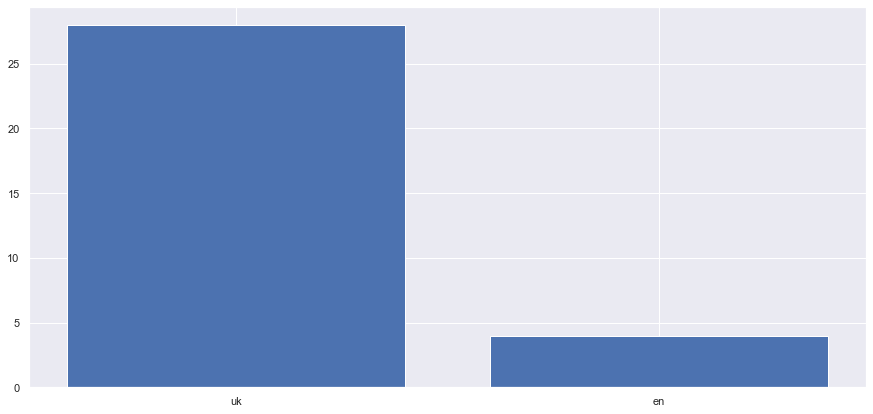

In [5]:
count_plot(corpus)

## Histogram of docs by # of words

/var/folders/gt/1_n_mc6n7ds4484kclg7pkjh0000gn/T/ipykernel_23261/3839128668.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


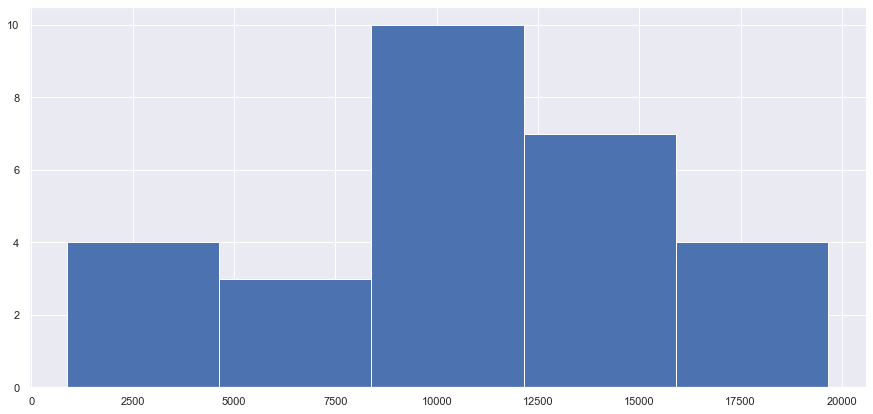

In [6]:
doc_length_plot(corpus)

In [7]:
def word_role_freq_plot(corpus: Dict[str, List[str]], lang: str = 'uk') -> None:
    def safe_dict_key_retrieval(key: str, dictionary: Dict[str, str]) -> str:
        try:
            return dictionary[key]
        except:
            return 'UNK'
        
    fig = plt.figure(figsize=(15,7))
    words = []
    if lang == 'en':
        tagsets = TAGSETS_EN
        nltk_lang = 'eng'
    else:
        tagsets = TAGSETS_RU
        nltk_lang = 'rus'
    texts = corpus[lang]
    texts_joined = ' '.join(texts).split()
    words = list(map(lambda x: safe_dict_key_retrieval(x[1], tagsets), nltk.pos_tag(texts_joined, lang=nltk_lang)))
    words = list(filter(lambda x: x!='UNK', words))
    words = Counter(words)
    keys = list(words.keys())
    counts = list(words.values())
    plt.bar(keys, counts)
    fig.show()

## Word roles frequency plot

/var/folders/gt/1_n_mc6n7ds4484kclg7pkjh0000gn/T/ipykernel_23261/689359624.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


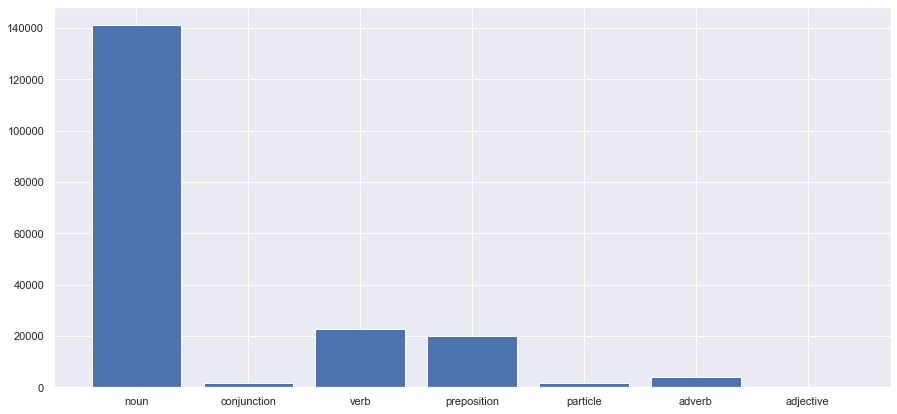

In [8]:
word_role_freq_plot(corpus)

In [9]:
def context_plot(word: str, corpus: Dict[str, str], ignored_words: List[str] = [], lang: str = 'uk') -> None:
    fig = plt.figure(figsize=(25,17))
    pattern = re.compile(r"[.!?]+")
    all_sentences = ' '.join(corpus[lang])
    all_sentences = nltk.sent_tokenize(all_sentences)
    all_sentences = [pattern.sub('', sentence) for sentence in all_sentences if len(sentence)>1]
    if lang == 'uk':
        stemmer = SnowballStemmer("russian") 
    else:
        stemmer = SnowballStemmer("english")
    all_sentences = [list(map(stemmer.stem, sentence.split())) for sentence in all_sentences]
    word = stemmer.stem(word)
    
    def swap_terms(dictionary: Dict[Tuple[str], int]) -> None:
        keys_old = list(dictionary.keys())
        for terms in keys_old:
            swapped_terms = terms[::-1]
            if swapped_terms==terms:
                continue
            if (swapped_terms in dictionary) and (terms in dictionary):
                val = dictionary.pop(swapped_terms)
                dictionary[terms] += val
                keys.remove(swapped_terms)
                
    finder = nltk.collocations.BigramCollocationFinder.from_documents(all_sentences)
    finder.apply_word_filter(lambda w: w.lower() in ignored_words)
    keys = list(filter(lambda x: x[0]==word or x[1]==word, finder.ngram_fd.keys()))
    bigrams = {bigram: value for bigram, value in finder.ngram_fd.items() if bigram in keys}
    swap_terms(bigrams)
    bigrams = dict(sorted(bigrams.items(), key=lambda item: -1*item[1]))
    bigrams = [(*bigram, value) for bigram, value in bigrams.items() if bigram in list(bigrams.keys())[:15]]
    G = nx.Graph()
    G.add_weighted_edges_from(bigrams)
    pos=nx.spring_layout(G)
    nx.draw(G, with_labels=True, font_weight='bold')
    labels = nx.get_edge_attributes(G, 'weight')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    return 

## Context plot

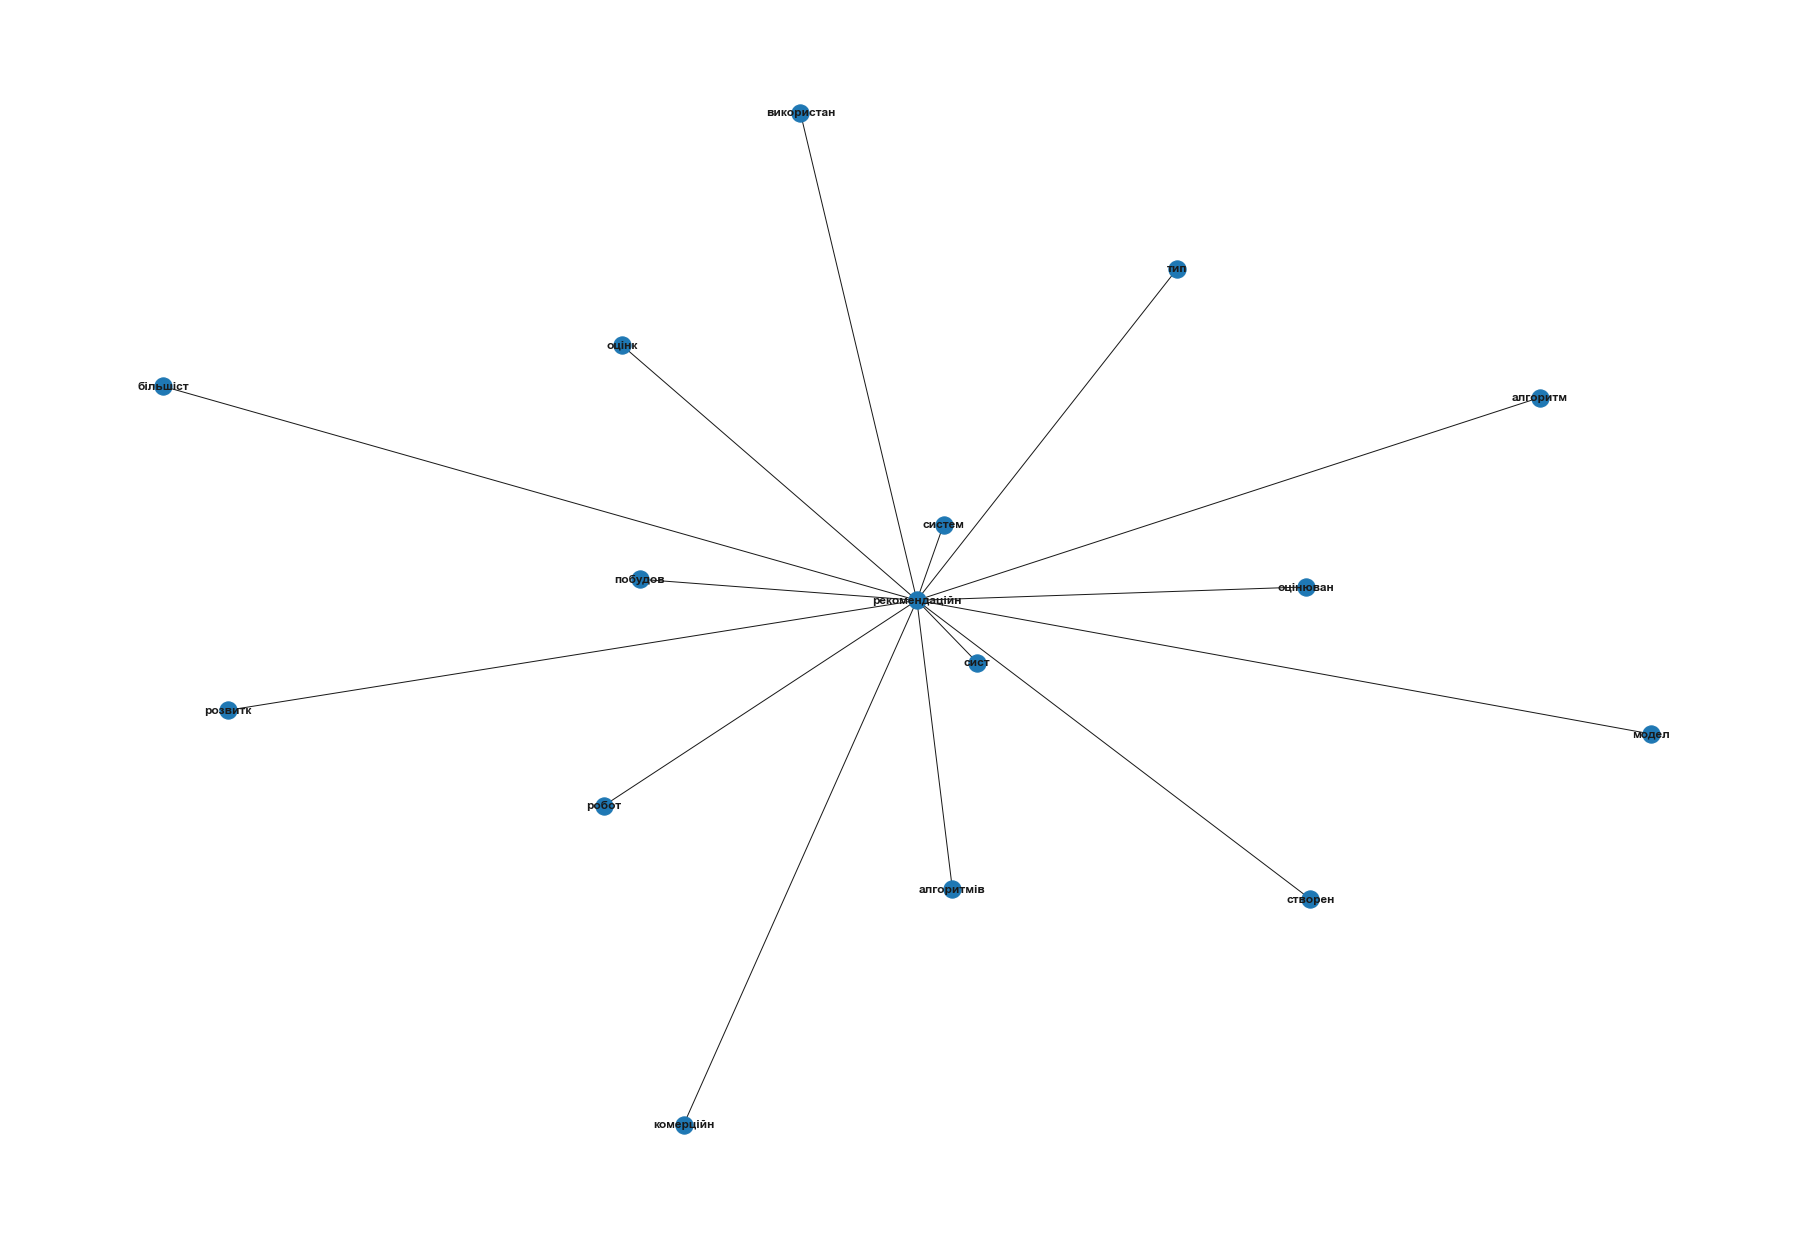

In [10]:
context_plot('рекомендаційна', corpus, ignored_words=STOPWORDS_UK)

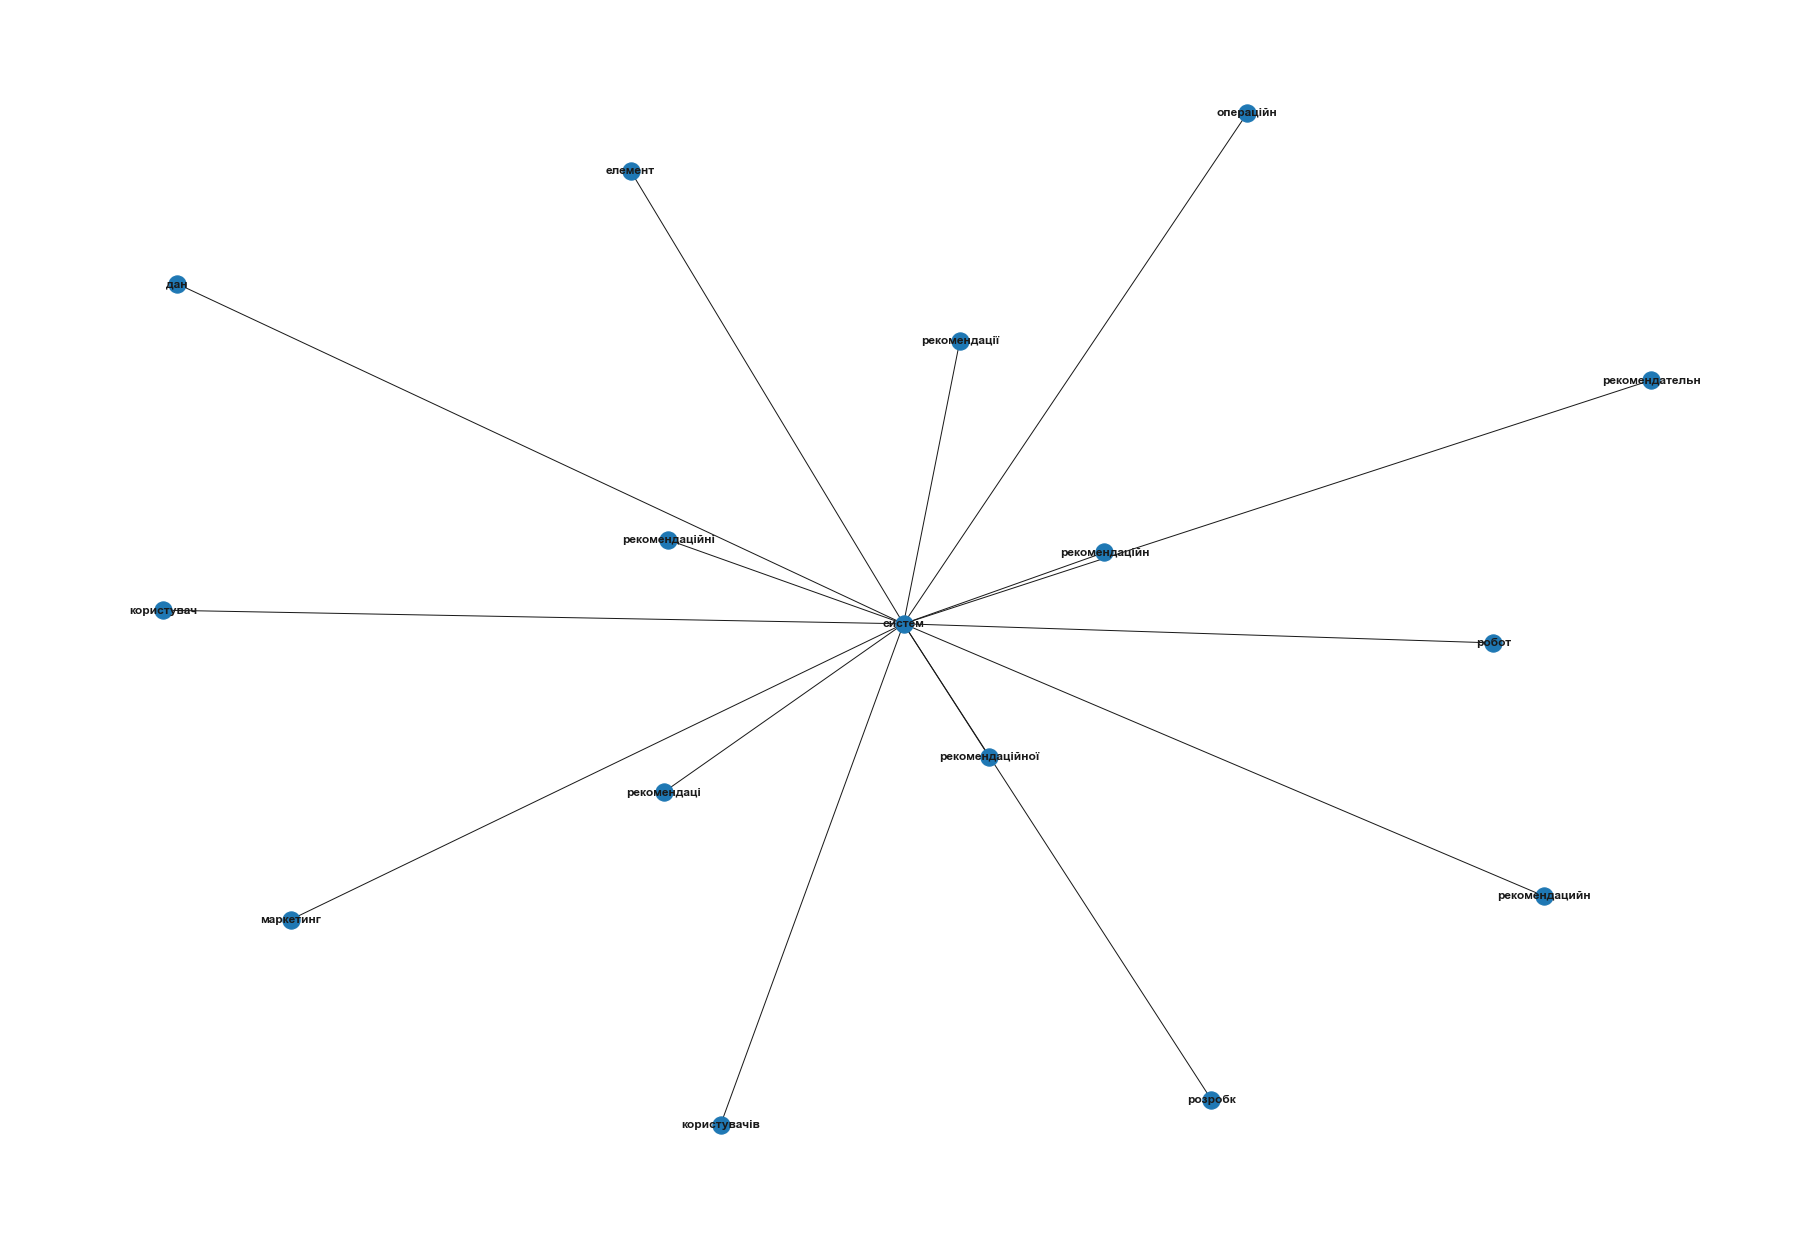

In [11]:
context_plot('система', corpus, ignored_words=STOPWORDS_UK)

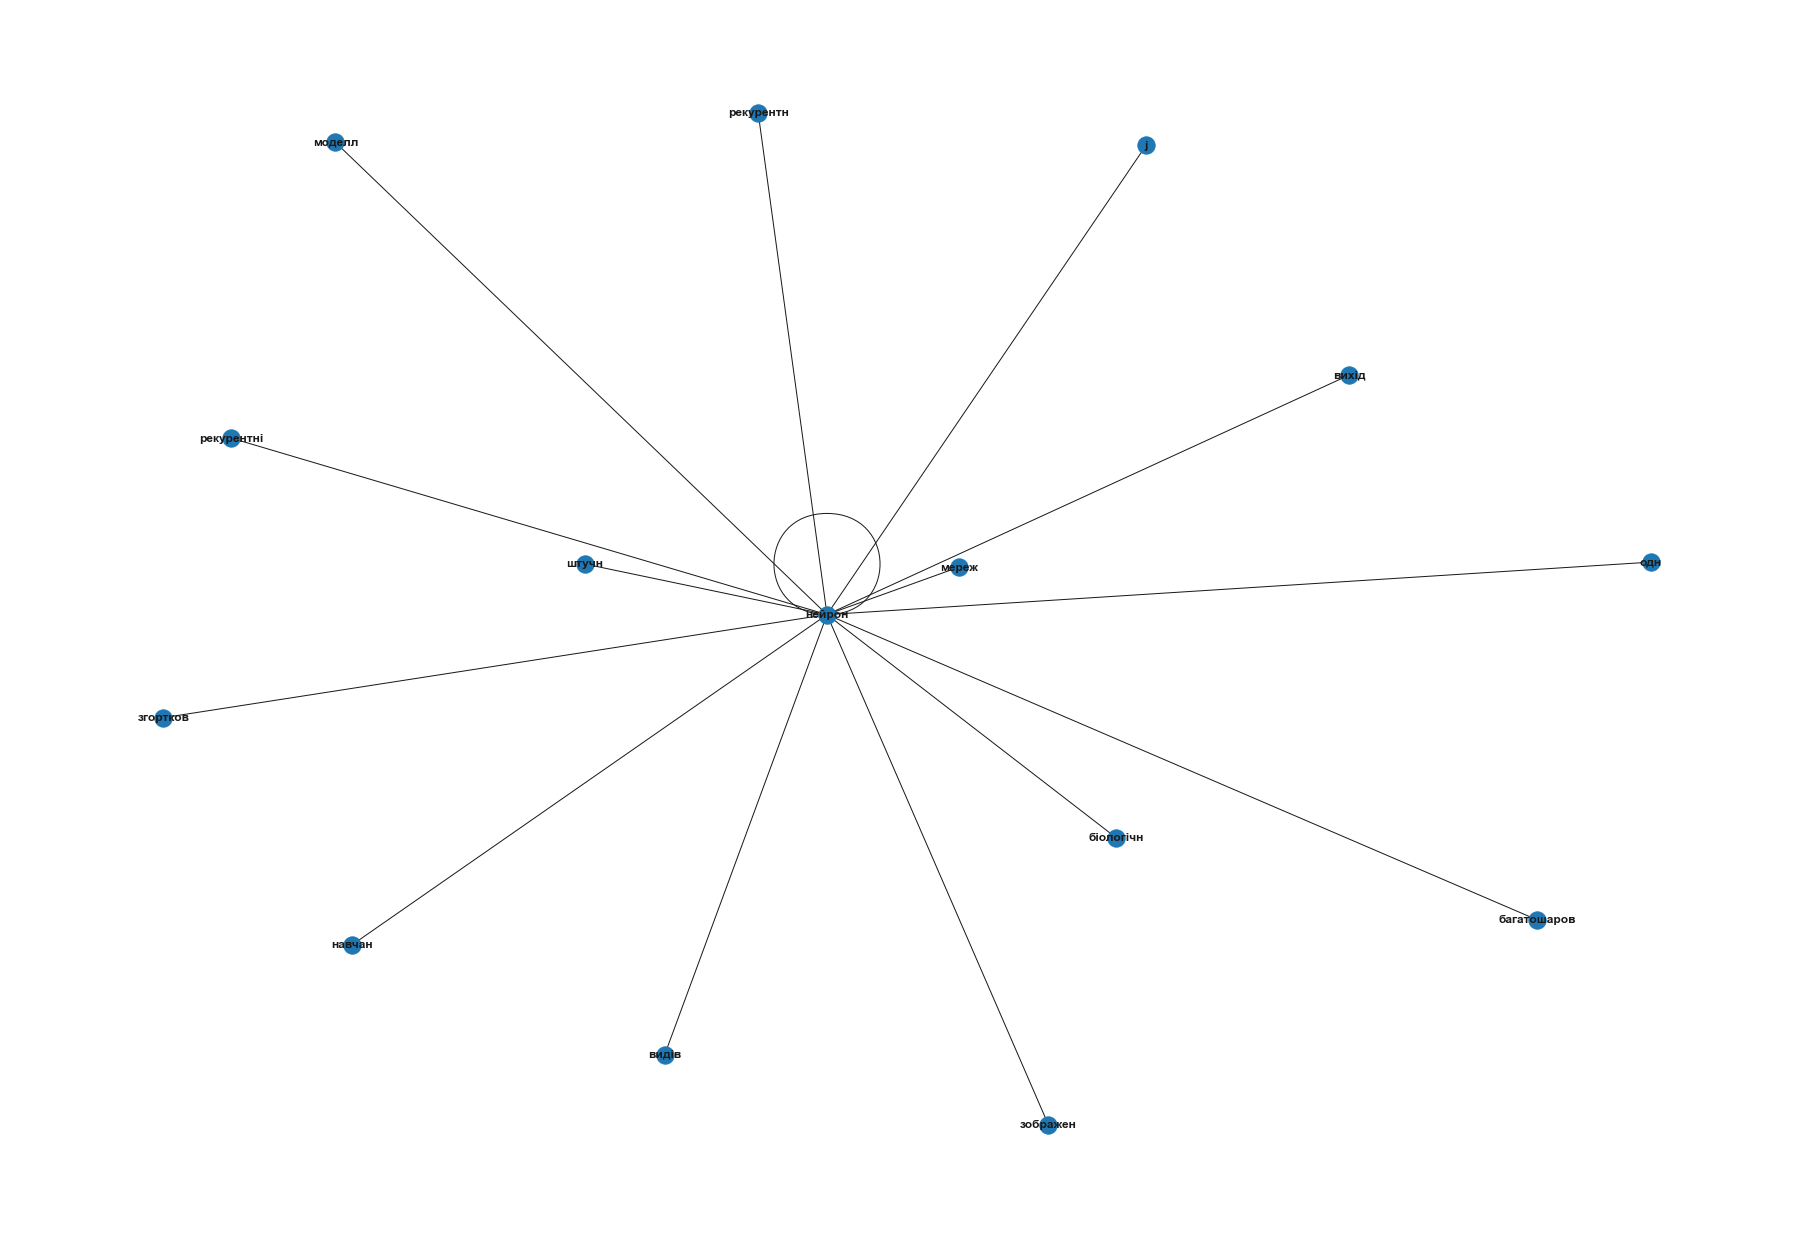

In [12]:
context_plot('нейронна', corpus, ignored_words=STOPWORDS_UK)

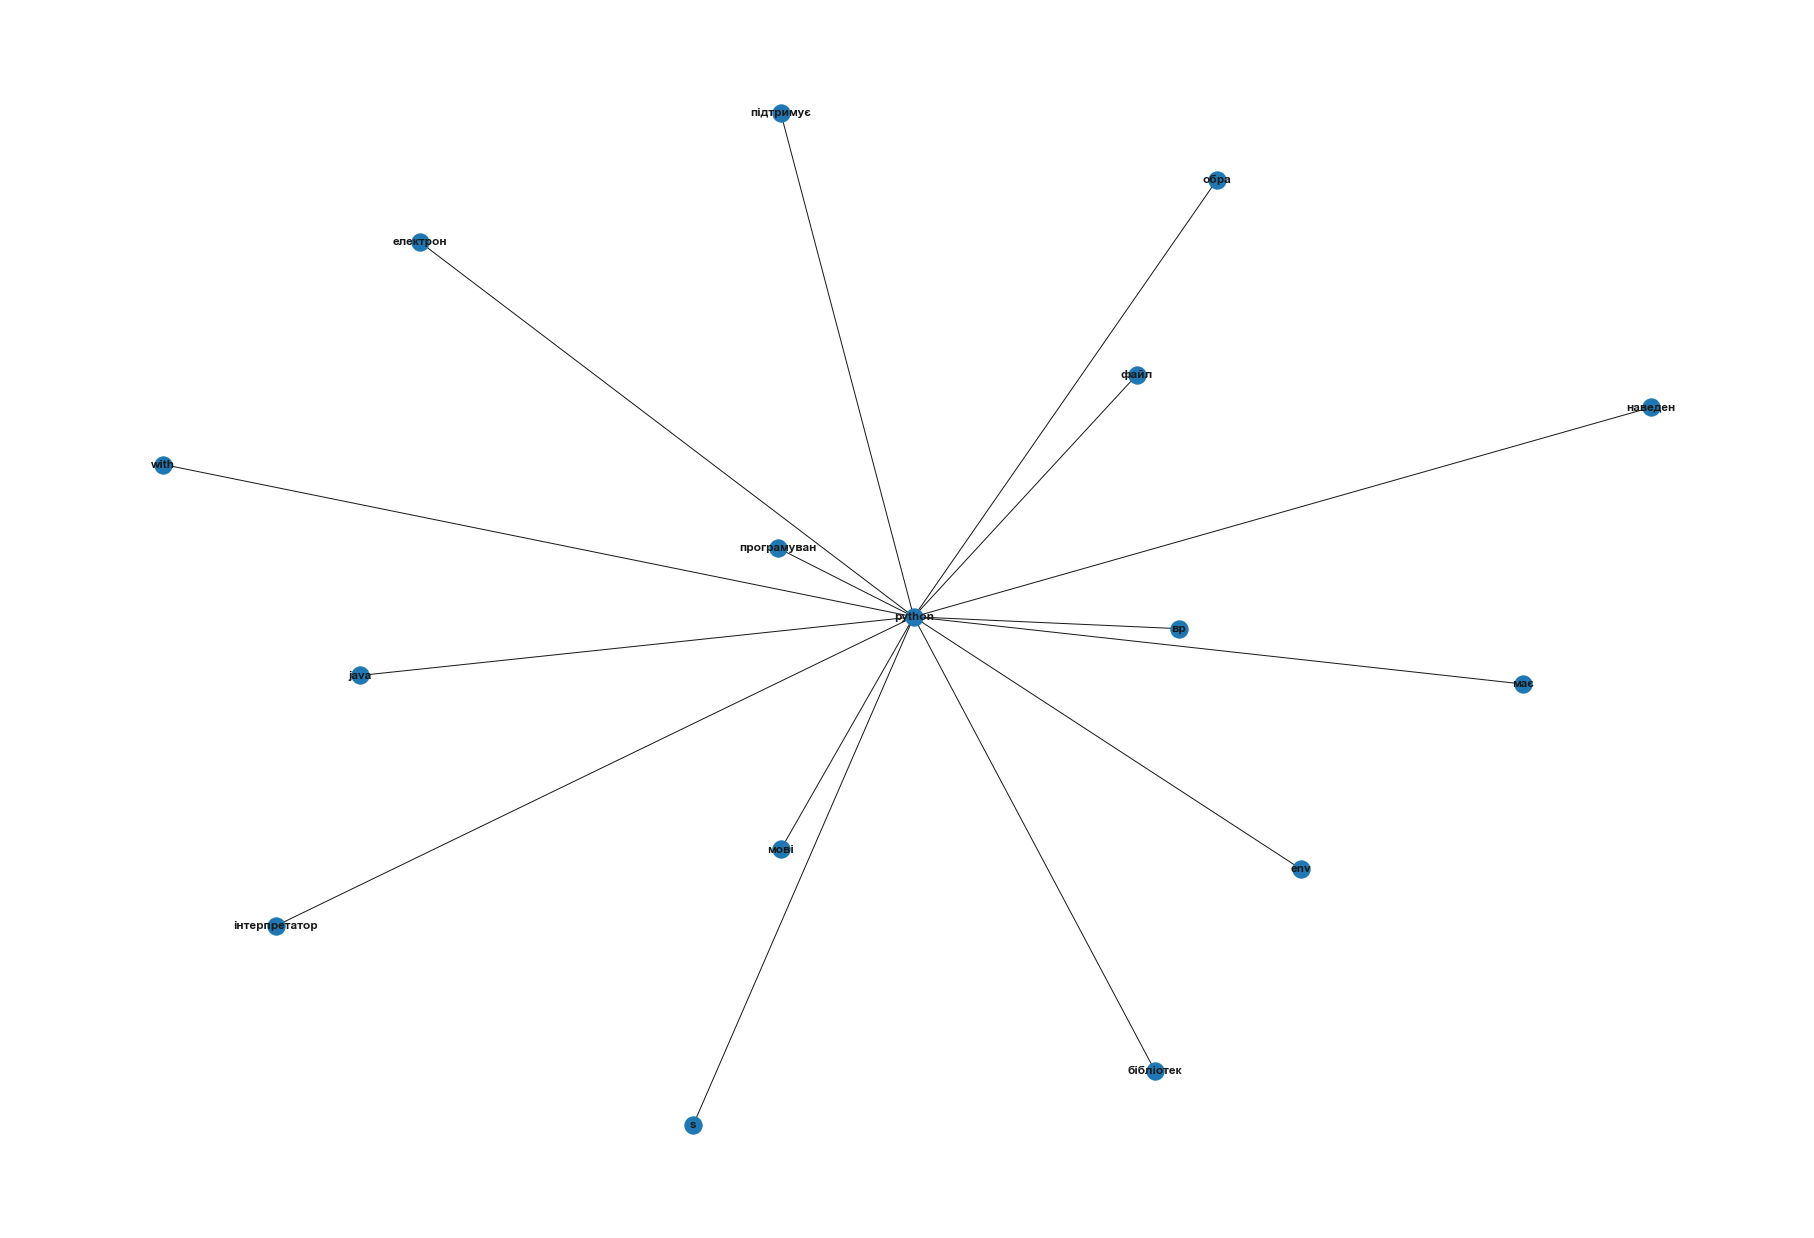

In [13]:
context_plot('python', corpus, ignored_words=STOPWORDS_UK)

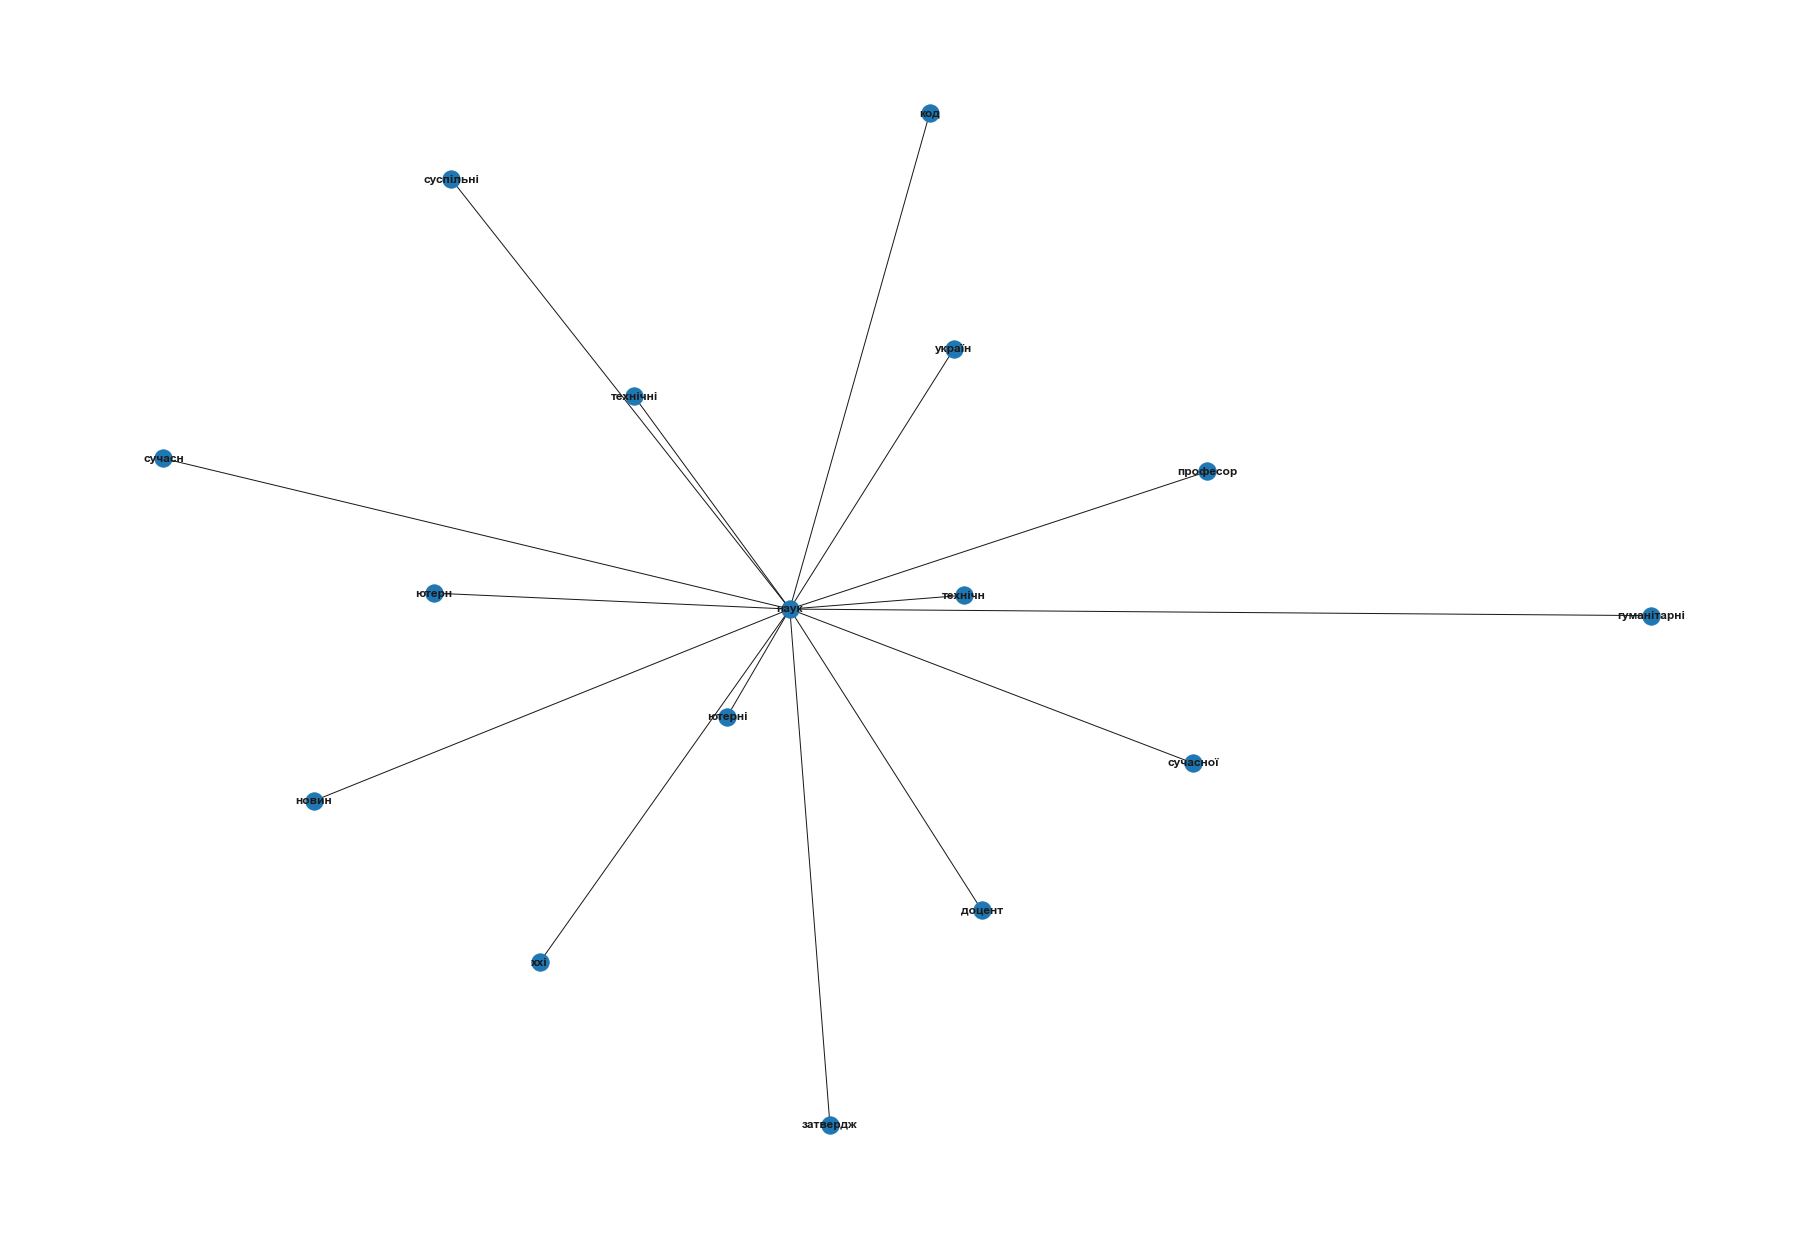

In [14]:
context_plot('наука', corpus, ignored_words=STOPWORDS_UK)

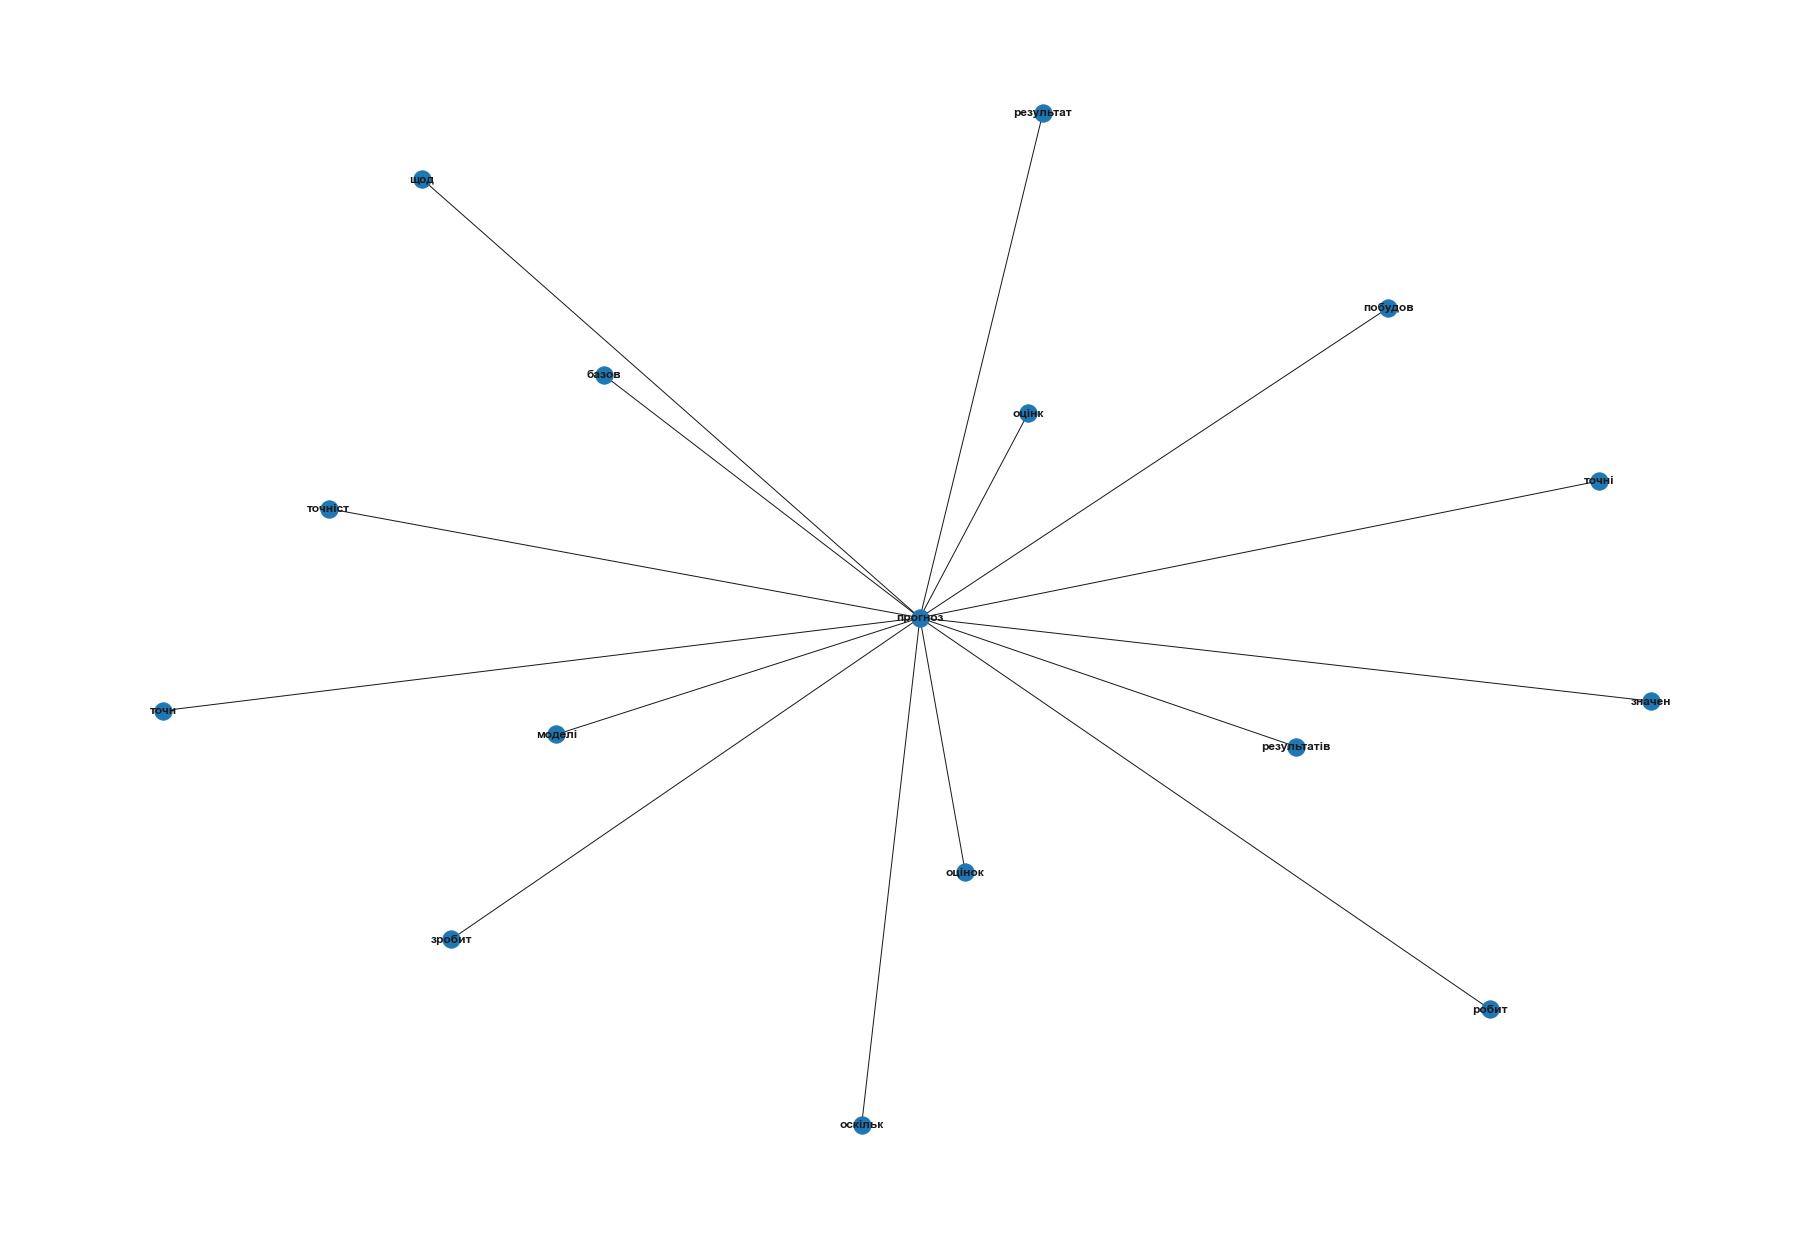

In [15]:
context_plot('прогноз', corpus, ignored_words=STOPWORDS_UK)

## Part 2. Text Clustering

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

### Instead of treating documents as corpus, we'll treat sentences as documents

In [17]:
all_sentences = ' '.join(corpus['uk'])
all_sentences = nltk.sent_tokenize(all_sentences)
all_sentences = [sentence for sentence in all_sentences if len(sentence)>1]
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + STOPWORDS_UK)
X = vectorizer.fit_transform(all_sentences)
svd = TruncatedSVD(32)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['адресу', 'базі', 'благо', 'бік', 'вигляді', 'винятком', 'випадку', 'випадок', 'вище', 'віддалік', 'відміну', 'відповідності', 'відповідь', 'дев', 'допомогою', 'залежності', 'засадах', 'зв', 'зважаючи', 'зверх', 'згідно', 'знак', 'знаком', 'зразок', 'користь', 'кшталт', 'ласка', 'ліворуч', 'межі', 'метою', 'мимо', 'міру', 'навкруги', 'нагоди', 'наоколо', 'наокруг', 'наокруги', 'напрямі', 'нарівні', 'насупротив', 'незалежно', 'основі', 'подаль', 'подалі', 'подібно', 'поодаль', 'поодалік', 'порівнянні', 'порівняно', 'посередництвом', 'праворуч', 'приводом', 'приводу', 'противагу', 'процесі', 'підставі', 'разом', 'рахунок', 'результаті', 'розрахунку', 'ролі', 'силу', 'слідом', 'сторону', 'судячи', 'супроводі', 'упритиск', 'упритул', 'ході', 'честь', 'чолі', 'язку', 'ятий', 

In [18]:
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.neighbors import NearestCentroid

### Benchmarking via K-means

In [19]:
def cluster_texts_kmeans(texts: np.ndarray, num_clusters: Union[int, List[int]]) -> None:
    if isinstance(num_clusters, int):
        num_clusters = [num_clusters]
    for n_clusters in num_clusters:
        print("NUMBER OF CLUSTERS: %d" % n_clusters)
        km = KMeans(n_clusters=n_clusters, init='k-means++')
        km.fit(X)
        print("Silhouette Coefficient: %0.3f" 
              % metrics.silhouette_score(X, km.labels_, sample_size=100))
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
        terms = vectorizer.get_feature_names()
        for i in range(n_clusters):
            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :10]:
                print(' %s' % terms[ind], end='')
            print()
        print("*"*10)


In [20]:
cluster_texts_kmeans(X, [3, 4, 5, 6, 8, 10, 12])

NUMBER OF CLUSTERS: 3
Silhouette Coefficient: 0.177
Cluster 0: даних системи аналіз роботи навчання рекомендацій систем програмного рекомендаційних рисунок
Cluster 1: користувачів користувача моделі роботи рекомендації навчання дані оцінок даних алгоритм
Cluster 2: systems based recommender user item роботи recommendation фільтрація filtering collaborative
**********
NUMBER OF CLUSTERS: 4
Silhouette Coefficient: 0.087
Cluster 0: користувачів моделі роботи навчання алгоритм даних оцінок дані кількість значення
Cluster 1: користувача рекомендації система користувачів основі дані товарів навчання користувач роботи
Cluster 2: systems based recommender user item роботи фільтрація recommendation filtering collaborative
Cluster 3: даних системи роботи аналіз навчання систем рекомендацій програмного рекомендаційних рисунок
**********
NUMBER OF CLUSTERS: 5
Silhouette Coefficient: 0.114
Cluster 0: навчання роботи моделі машинного користувачів алгоритм дані мережі даних програмного
Cluster 1: sys

### Benchmarking via Agglomerative Clustering

In [21]:
def cluster_texts_agglomerative(texts: np.ndarray, num_clusters: Union[int, List[int]]) -> None:
    if isinstance(num_clusters, int):
        num_clusters = [num_clusters]
    for n_clusters in num_clusters:
        print("NUMBER OF CLUSTERS: %d" % n_clusters)
        ac = AgglomerativeClustering(n_clusters=n_clusters)
        y_predict = ac.fit_predict(X)
        print("Silhouette Coefficient: %0.3f" 
              % metrics.silhouette_score(X, y_predict, sample_size=1000))
        km = NearestCentroid()
        km.fit(X, y_predict)
        original_space_centroids = svd.inverse_transform(km.centroids_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
        terms = vectorizer.get_feature_names()
        for i in range(n_clusters):
            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :10]:
                print(' %s' % terms[ind], end='')
            print()
        print("*"*10)

In [22]:
cluster_texts_agglomerative(X, [3, 4, 5, 6, 8, 10, 12])

NUMBER OF CLUSTERS: 3
Silhouette Coefficient: 0.089
Cluster 0: даних роботи системи навчання аналіз рекомендацій систем користувача моделі програмного
Cluster 1: systems based recommender user item роботи pp recommendation фільтрація filtering
Cluster 2: користувачів користувача моделі рекомендації дані навчання роботи оцінок користувач система
**********
NUMBER OF CLUSTERS: 4
Silhouette Coefficient: 0.083
Cluster 0: користувачів користувача моделі рекомендації дані навчання роботи оцінок користувач система
Cluster 1: systems based recommender user item роботи pp recommendation фільтрація filtering
Cluster 2: роботи системи навчання рекомендацій систем аналіз програмного користувача рекомендаційних моделі
Cluster 3: даних бази користувачів користувача опис вхідних набору аналізу кількості аналіз
**********
NUMBER OF CLUSTERS: 5
Silhouette Coefficient: 0.073
Cluster 0: роботи системи навчання рекомендацій систем аналіз програмного користувача рекомендаційних моделі
Cluster 1: користувач

## Part 3. Topic modelling
### We'll perform that via Doc2Vec model

In [84]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [85]:
pattern = re.compile(r"[.!?]+")
all_sentences = ' '.join(corpus['uk'])
all_sentences = nltk.sent_tokenize(all_sentences)
all_sentences = [pattern.sub(' ', sentence) for sentence in all_sentences if len(sentence)>1]
all_sentences = [list(filter(lambda x: len(x)>2, sentence.split())) for sentence in all_sentences]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_sentences)]
model = Doc2Vec(documents, vector_size=32, window=15, min_count=1, workers=4)

In [86]:
X = np.stack([model.infer_vector(sentence) for sentence in all_sentences])

In [ ]:
def cluster_texts_word2vec_kmeans(texts: np.ndarray, num_clusters: Union[int, List[int]]) -> None:
    if isinstance(num_clusters, int):
        num_clusters = [num_clusters]
    for n_clusters in num_clusters:
        print("NUMBER OF CLUSTERS: %d" % n_clusters)
        km = KMeans(n_clusters=n_clusters, init='k-means++')
        km.fit(X)
        print("Silhouette Coefficient: %0.3f" 
              % metrics.silhouette_score(X, km.labels_, sample_size=1000))
        centers = km.cluster_centers_
        for i, c in enumerate(centers):
            similar_words = list(map(lambda x: x[0], model.wv.most_similar(c, topn=15)))
            print("Cluster %d:" % i, end=' ')
            print(', '.join(similar_words))
        print("*"*10)

In [ ]:
cluster_texts_word2vec_kmeans(X, [3, 4, 5, 6])

## Step 4. Rule-based clustering
### Rule based clustering will be performed via finding most important n-grams in each topic

In [79]:
def rule_based_clustering(num_clusters: int, topn: int = 25):
    def cluster_by_rule(sentence: str, rules: List[List[str]]) -> int:
        for idx, rule_set in enumerate(rules):
            if any([rule in sentence for rule in rule_set]):
                return idx
        return -1
    km = KMeans(n_clusters=num_clusters, init='k-means++')
    km.fit(X)
    y = km.predict(X)
    pattern = re.compile(r"[^а-яіїє ]+")
    full_corpus = list(map(lambda x: ' '.join(x), np.asarray([[pattern.sub('', x) for x in corpus if len(x)>3] for corpus in all_sentences]).tolist()))
    rules = []
    print('Generating Rules...')
    for cluster in range(num_clusters):
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=STOPWORDS_UK)
        vecs = vectorizer.fit_transform(np.asarray(full_corpus)[y==cluster].tolist())
        words = np.asarray(vectorizer.get_feature_names())
        idfs = vectorizer.idf_
        scores = np.mean(vecs.toarray(), axis=0)*idfs
        argsorted_scores = scores.argsort()[::-1]
        cluster_rule = words[argsorted_scores[:topn]]
        print("Cluster %d rule: %s" %(cluster, '\' OR \''.join(cluster_rule)))
        rules.append(cluster_rule)
    print('Rules Evaluation...')
    y_r = list(map(lambda text: cluster_by_rule(text, rules), full_corpus))
    print(classification_report(y, y_r))
    

In [80]:
from sklearn.metrics import classification_report

In [81]:
rule_based_clustering(3, 100)

/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['адресу', 'базі', 'благо', 'бік', 'вигляді', 'винятком', 'випадку', 'випадок', 'вище', 'віддалік', 'відміну', 'відповідності', 'відповідь', 'дев', 'допомогою', 'залежності', 'засадах', 'зв', 'зважаючи', 'зверх', 'згідно', 'знак', 'знаком', 'зразок', 'користь', 'кшталт', 'ласка', 'ліворуч', 'межі', 'метою', 'мимо', 'міру', 'навкруги', 'нагоди', 'наоколо', 'наокруг', 'наокруги'

Generating Rules...
Cluster 0 rule: докум' OR 'підп' OR 'даних' OR 'системи' OR 'рекомендацій' OR 'користувачів' OR 'користувача' OR 'рисунок' OR 'дата' OR 'роботи' OR 'моделі' OR 'рекомендації' OR 'основі' OR 'систем' OR 'алгоритм' OR 'фільтрації' OR 'аналіз' OR 'електронний' OR 'ресурс' OR 'електронний ресурс' OR 'доступу' OR 'дані' OR 'модель' OR 'система' OR 'режим доступу' OR 'режим' OR 'товарів' OR 'оцінки' OR 'навчання' OR 'рекомендаційних' OR 'користувач' OR 'таблиці' OR 'дослідження' OR 'розділ' OR 'алгоритму' OR 'кількість' OR 'методів' OR 'методи' OR 'опис' OR 'методу' OR 'інформації' OR 'значення' OR 'рисунку' OR 'алгоритмів' OR 'використання' OR 'прогнозування' OR 'допомогою' OR 'розробки' OR 'якості' OR 'метод' OR 'елементів' OR 'аналізу' OR 'створення' OR 'фільтрація' OR 'колаборативної' OR 'рекомендаційних систем' OR 'оцінок' OR 'кількості' OR 'рекомендаційної' OR 'реалізації' OR 'результати' OR 'визначення' OR 'крок' OR 'колаборативної фільтрації' OR 'матриці' OR 'зада

/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
